In [26]:
import functools
import jax
import os

from datetime import datetime
from jax import numpy as jp
import matplotlib.pyplot as plt
from IPython.display import HTML, clear_output

import brax
import flax
from brax import envs
from brax.io import model
from brax.io import json
from brax.io import html
from brax.training.agents.ppo import train as ppo
from brax.training.agents.sac import train as sac

import time
from datetime import datetime

In [3]:
from two_axis_inverted_pendulum_env import TwoAxisInvertedPendulum
from brax.envs.base import Env, PipelineEnv, State

In [5]:
envs.register_environment("TwoAxisInvertedPendulum", TwoAxisInvertedPendulum)
env = envs.get_environment("TwoAxisInvertedPendulum")

# required for parallelizing training
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

# Initial Rollout
Just to see that it works

In [21]:
rng = jax.random.PRNGKey(0)
state = jit_reset(rng)
rollout = [state.pipeline_state]

for _ in range(1000):
    rng, _ = jax.random.split(rng)
    action = jax.random.uniform(rng, (env.action_size,), minval=-2, maxval=2) # i forgot the actual limits
    state = jit_step(state, action)
    if state.done == 1: 
        state = jit_reset(rng)
    rollout.append(state.pipeline_state)

# uncommend if  line rendered
# HTML(html.render(env.sys.tree_replace({'opt.timestep': env.dt}), rollout))

# render to save to file
html_content = html.render(env.sys, rollout)
with open('untrained_rollout.html', 'w') as out:
    out.write(html_content)

# Training

## Using functools
For my future use:
- `reward_scaling`: ...
- `action_repeat`: ...
- `unroll_length`: ...

In [22]:
train_fn = functools.partial(
    ppo.train,
    num_timesteps=20_000_000, 
    num_evals=20,
    reward_scaling=1,
    episode_length=1000, 
    normalize_observations=True,
    action_repeat=1,
    unroll_length=10, #original was 5
    num_minibatches=32,
    num_updates_per_batch=4,
    discounting=0.97,
    learning_rate=3e-4,
    entropy_cost=1e-2,
    num_envs=4096, # the number of parallel 
    batch_size=2048,
    seed=1
)

In [27]:
# code was borrowed from Brax's `tutorial` collab notebook

xdata, ydata = [], []
times = [datetime.now()]

def progress(num_steps, metrics):
    times.append(datetime.now())
    xdata.append(num_steps)
    ydata.append(metrics['eval/episode_reward'])
    clear_output(wait=True)
    plt.xlim([0, train_fn.keywords['num_timesteps']])
    plt.xlabel('# environment steps')
    plt.ylabel('reward per episode')
    plt.plot(xdata, ydata)
    plt.show()


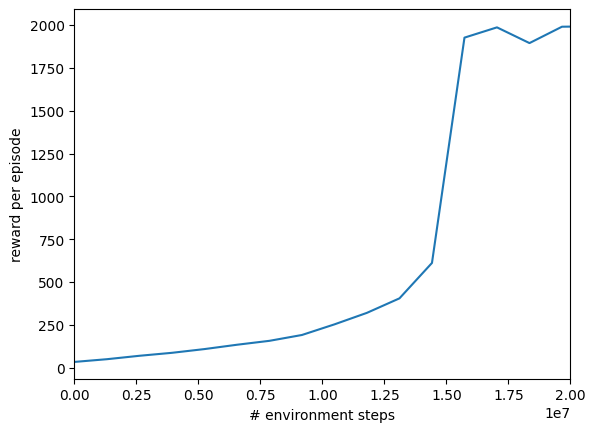

In [28]:
time_start = time.time()
make_inference_fn, params, metrics = train_fn(
    environment=env,
    progress_fn=progress)
time_end = time.time()

In [29]:
model.save_params("two_axis_pendulum_policy", params)
params = model.load_params("two_axis_pendulum_policy")
inference_fn = make_inference_fn(params) 

In [32]:
# After training, create rollout
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)
jit_inference_fn = jax.jit(inference_fn)

rollout = []
rng = jax.random.PRNGKey(0)
state = jit_reset(rng=rng)

for _ in range(1000):
    rollout.append(state.pipeline_state)
    act_rng, rng = jax.random.split(rng)
    act, _ = jit_inference_fn(state.obs, act_rng)
    if state.done != 0:
        state = jit_reset(rng)
    else:
        state = jit_step(state, act)

    

# Generate HTML
html_content = html.render(env.sys, rollout)
with open('trained_rollout.html', 'w') as f:
    f.write(html_content)